In [1]:
#standard imports
import detprocess as dp
from pathlib import Path
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import math
import qetpy as qp

from pytesdaq.io.hdf5 import H5Reader, getrandevents

from scipy import stats, optimize

from matplotlib import rc
rc('text', usetex=False)
rc('font', family="sans-serif")
rc('axes', labelsize=12)
rc('font', size=12)
rc('legend', fontsize=10)
rc('xtick', labelsize=12)
rc('ytick', labelsize=12)

h5_reader = H5Reader()

/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
run = 18
#series = '20211001_0847'
#version = 5
#suffix = ''

trigger_path = '/data/users/da_real_maggie_reed/processed/run18/trigger6sigmav6_I2_D20220802_T113426'
yaml_path = '/data/users/da_real_maggie_reed/analysis/run_18/data/run18_morerandoms_lowtempv4.yaml'
save_path = '/data/users/da_real_maggie_reed/processed/run18/deptprocess_morerandoms_lowtempv4_I2_D20220628_T132125'
if not Path(save_path).is_dir():
    raise OSError(f"Please create {save_path} for saving processed files.")
series = [Path(s).parts[-1] for s in sorted(glob(f"{trigger_path}*"))]

In [16]:
#process over our data
#for ii, file in enumerate(sorted(glob(f"{trigger_path}/*.hdf5"))):
    df = dp.process_data(
        file,
        yaml_path,
        savepath=save_path, # pass None if you don't want to save the file (for debugging)
        #nevents=10, # process only the first 10 events (for debugging)
        #external_file=None, # set to the path to an external file that contains different features than the default (see the README for more info)
    )
    print(ii)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [3]:
#loads all the features we got from the hdf5 made by dp
#returns a dataframe
#files are already created and ready to go from a prior build
df = dp.io.load_features(save_path)

In [4]:

df.keys()
goodtemp_up = np.loadtxt('/data/users/da_real_maggie_reed/analysis/run_18/templatevf_upvf_I2_D20220628_T132125.txt')
goodtemp_low = np.loadtxt('/data/users/da_real_maggie_reed/analysis/run_18/templatevf_lowvf_I2_D20220628_T132125.txt')
template = np.loadtxt('/data/users/da_real_maggie_reed/analysis/run_18/templatev3_lowv2_6sigmav4_I2_D20220628_T210658.txt')

In [6]:
ctrigger = df.triggertype == 1
crandoms = df.triggertype == 0
#cmask_nochi2 = ctrigger&cgood_time&cbaseline1
fs = 1.25e6
tracelength = 20e-3

from scipy import constants

m_run10 = 8.045875997742481e-08
calibratedofamp = df.ofamp_unconstrained_CPDv21Ge/m_run10
calibratedofamp_nodelay = df.ofamp_nodelay_CPDv21Ge/m_run10
calibratedenergy = -((df.energyabsorbed_CPDv21Ge/constants.e)/161)
calibratedofamp_constrained = df.ofamp_constrained_CPDv21Ge/m_run10

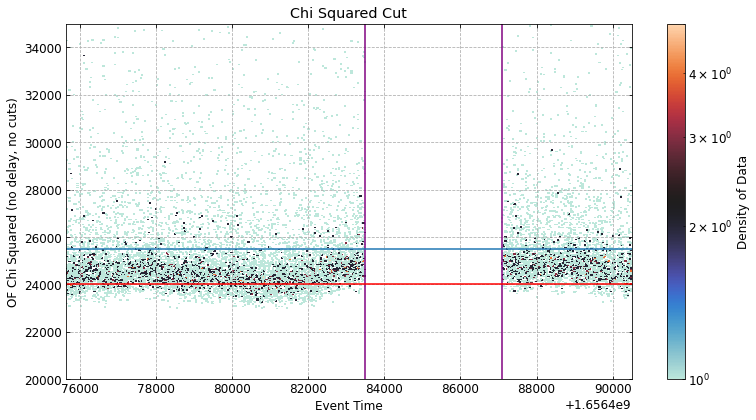

In [70]:
fig, ax = dp.densityplot(
    df.eventtime,
    df.ofchi2_nodelay_CPDv21Ge,
    cut=ctrigger&cgood_time&ctemp_splitpop,
    ylims=[0.2e5, 0.35e5],
  #  xlims=[0, 1.2],
)
ax.axvline(83500+1.6564e9,c='purple')
ax.axvline(87100+1.6564e9,c='purple')
#number of dof per trace (chi2 mean)
ax.axhline((fs*tracelength)-1e3,c='r')
ax.axhline(25500)
ax.set_xlabel('Event Time')
ax.set_ylabel('OF Chi Squared (no delay, no cuts)')
ax.set_title('Chi Squared Cut')
fig.tight_layout()

In [7]:

ctime0=(df.eventtime<90500+1.6564e9)
cchisquared = dp.inrange(df.ofchi2_nodelay_CPDv21Ge,-np.inf,25500)
ctime_early = (df.eventtime<83500+1.6564e9)
ctime_mid_noisy = ((df.eventtime>83500+1.6564e9)&(df.eventtime<87100+1.6564e9))
ctime_late = (df.eventtime>87100+1.6564e9)
cgood_time = ctime0&np.invert(ctime_mid_noisy)

In [8]:
tot_time = df.eventtime[ctrigger&cgood_time].iloc[-1]-df.eventtime[ctrigger&cgood_time].iloc[0]

#events_upper = sum(ctemp_up[ctrigger&cgood_time])/tot_time

#print('the rate of events in the lower distribution is:',events_lower,'\n')


In [9]:
#more rigorous baseline cut
#binning the event time into 400s bins and then finding baseline cut that cuts 10% of high end of baseline in each bin
import math
start_time=df.eventtime[ctrigger].iloc[0]
binsize=400 #size in seconds of each bin used to partition eventtime for baseline cutting
binnumber=tot_time/binsize

cbaseline1_list=np.empty(math.ceil(binnumber),dtype='object')

for i in range(math.floor(binnumber)):
    ctime_temp = dp.inrange(df.eventtime,(binsize*i)+start_time,(binsize*(i+1))+start_time)
    cut_value=np.percentile(df.baseline_CPDv21Ge[ctime_temp],90)
    cbaseline1_list[i]=dp.inrange(df.baseline_CPDv21Ge,-np.inf,cut_value)&ctime_temp

if math.floor(binnumber)!=math.ceil(binnumber): #this fills in the cut for the last time bin, which isn't the full length of the other time bins unless your bin size perfectly divides your total time 
    ctime_temp=dp.inrange(df.eventtime,(binsize*math.floor(binnumber))+start_time,start_time+tot_time)
    cut_value=np.percentile(df.baseline_CPDv21Ge[ctime_temp],90)
    cbaseline1_list[-1]=dp.inrange(df.baseline_CPDv21Ge,-np.inf,cut_value)&ctime_temp

In [10]:
#more rigorous baseline cut
cbaseline1=cbaseline1_list[0]
for i in range(len(cbaseline1_list)):
    cbaseline1=cbaseline1|cbaseline1_list[i] #this takes all the baseline cuts from the previous step and bitwise ORs them into one cut


In [27]:
m1_strict = 20
b1_strict = 26200

m_loose = 170
b_loose = 0.252e5 

x_loose_fittingcalib=np.arange(0,80,0.1)
x_fitting_strictcalb = np.arange(0,39,0.1)
y_loose_parabcalib_low=b_loose+m_loose*x_loose_fittingcalib**2 
y_strict_parabcalib = b1_strict+m1_strict*x_fitting_strictcalb**2
#y_loose_root_calib = b_loose+m_loose*np.sqrt(x_loose_fittingcalib-25)
temp_func = lambda x, m, b: m * x**2 + b
temp_func_root = lambda x, m, b: m * np.sqrt(x) + b

ctemp_loose=((df.ofchi2_constrained_CPDv21Ge) < 
                           (temp_func(calibratedofamp_constrained,
                           m_loose,b_loose))) | (df.ofchi2_constrained_CPDv21Ge<
                                                       (dp.inrange(calibratedofamp_constrained,70,np.inf))
                                                      )
'''
ctemp_loose = (((df.ofchi2_unconstrained_CPDv21Ge) < 
                           (temp_func(dp.inrange(calibratedofamp,0,25),
                            m1_strict, b1_strict)))&

ctemp_root = (((df.ofchi2_unconstrained_CPDv21Ge)<
                            (temp_func_root(calibratedofamp,
                             m_loose,b_loose)))&(
    (df.ofchi2_unconstrained_CPDv21Ge)<(dp.inrange(calibratedofamp,70,np.inf))))
    '''
ctemp_low = (((df.ofchi2_constrained_CPDv21Ge < temp_func(calibratedofamp_constrained, m1_strict, b1_strict)))&
            dp.inrange(calibratedofamp_constrained,0,37))
ctemp_up = (np.invert(ctemp_low)&dp.inrange(calibratedofamp_constrained,0,80))

ctemp_tenfifteenkev = dp.inrange(calibratedofamp_constrained, 10, 15)

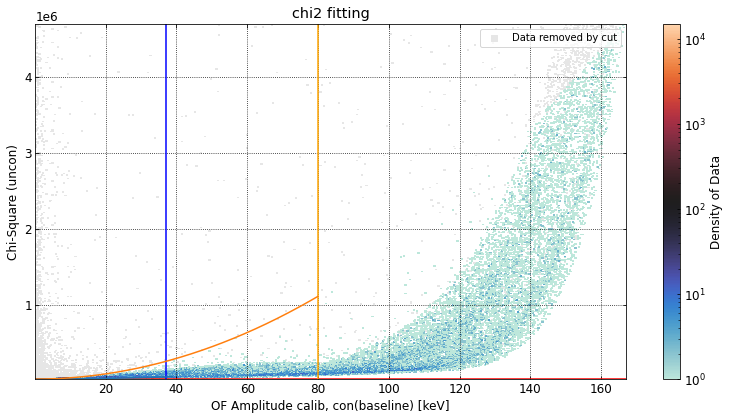

In [34]:
#checking the fit of our amplitudes v chi2
#a "good" fit against chi2 will be about ~ number of bins
fig, ax = dp.densityplot(
    df.ofamp_constrained_CPDv21Ge/m_run10,
    df.ofchi2_constrained_CPDv21Ge,
    cut=ctrigger&cgood_time&cbaseline1&ctemp_loose,
    #ylims=[2e4, 8e7],
    #xlims=[0, 120],
    plot_cut_data = True,
    basecut = ctrigger&cgood_time,
)

ax.set_title('chi2 fitting')
ax.set_ylabel(r'Chi-Square (uncon)')
ax.set_xlabel(r'OF Amplitude calib, con(baseline) [keV]')
ax.tick_params(which='both', direction='in', top=True, right=True)
ax.grid(b=True, linestyle='dotted', color='k', zorder=10)

ax.axhline((fs*tracelength),c='r')
ax.axvline(37, c='blue')
ax.axvline(80, c='orange')


ax.plot(x_fitting_strictcalb,y_strict_parabcalib)
ax.plot(x_loose_fittingcalib,y_loose_parabcalib_low)
fig.tight_layout()
'''
fig.savefig(
    '/data/users/da_real_maggie_reed/analysis/run_18/figs/chi2fits_zoomout_final.png',
    dpi=500,
    facecolor='none',
)
#''';

In [ ]:
#this creates a chi squared cut to use on randoms, that selects data with chi squared within 3 standard deviations of the mean
#in a chi squared distribution, the mean is the number of degrees of freedom and the variance is twice that
#the st dev is the square root of the variance
samplerate=fs
chi_thresh= int(tracelength*samplerate) + 3 * np.sqrt(2 * int(tracelength*samplerate))
chi_thresh_lower= int(tracelength*samplerate) - 3 * np.sqrt(2 * int(tracelength*samplerate))
crandschisqared = ((df.ofchi2_nodelay_CPDv21Ge < chi_thresh) & (df.ofchi2_nodelay_CPDv21Ge > chi_thresh_lower))

Text(0, 0.5, 'calibrated energy abs [kev]')

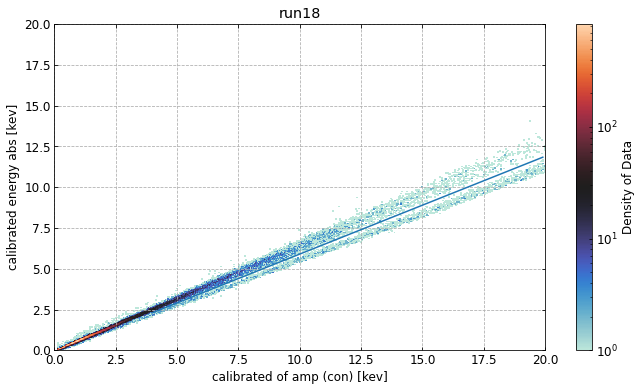

In [73]:
#slightly off from a one to one ratio by a factor of energyabsorbed*1.6
fig, ax = dp.densityplot(
    calibratedofamp_constrained,
    calibratedenergy,
    cut= ctrigger&cgood_time&cbaseline1&ctemp_loose,
    xlims=(0,20),
    ylims=(0,20)
   # ylims=(-3.25,-2)
    )
ax.plot(x_fitting_strictcalb, y_strict_lin)
#ax.axline((1,1), xy2=(20,12.4), color = 'red')
ax.set_title('run18')
ax.set_xlabel('calibrated of amp (con) [kev]')
ax.set_ylabel('calibrated energy abs [kev]')

In [46]:
m_splitpop = 0.6
b_splitpop = 2.3

x_fitting_strictcalb = np.arange(4,20,0.1)
y_strict_lin = b_splitpop+m_splitpop*(x_fitting_strictcalb-4)

temp_funclin = lambda x, m, b: m * (x-4) + b


In [50]:

ctemp_splitpop = (((calibratedenergy > temp_funclin(calibratedofamp_constrained,
                                                             m_splitpop, b_splitpop)))&
            dp.inrange(calibratedofamp_nodelay,4,20))
ctemp_splitpop2 = (((calibratedenergy < temp_funclin(calibratedofamp_constrained,
                                                             m_splitpop, b_splitpop)))&
            dp.inrange(calibratedofamp_nodelay,4,20))
ctemp_lessthan15kev = dp.inrange(calibratedenergy, 0, 15)
ctemp_splitpop = ctemp_splitpop & ctemp_lessthan15kev

# Checking rates for different populations and energy ranges

In [57]:
#ctrigger&cgoodtime,cbaseline,ctemp_loose, cplitpop
cfoursevenkev=dp.inrange(calibratedofamp_constrained,4,7)
cseventenkev=dp.inrange(calibratedofamp_constrained,7,10)
ctentwentykev = dp.inrange(calibratedofamp_constrained,10,20)
callev = dp.inrange(calibratedofamp_constrained, 4,20)

In [59]:
#cutting efficiency tables for 240 us template cuts
#cbaselinelow,cpresat_low_uncon,ctemplow_strict,cdel_low
#ctemp_low = 
cut_list = [cgood_time,cbaseline1, ctemp_loose, ctemp_splitpop]
index_list = ['time','baseline','chi2', 'gaas']
energy_list = [cfoursevenkev, cseventenkev, ctentwentykev, callev]
cols_list = ['Randoms - Differential Efficiency','Randoms - Total Efficiency','Trigger (4-7keV) - Differential Efficiency','Trigger (4-7keV) - Total Efficiency','Trigger (7-10) - Differential Efficiency','Trigger (7-10) - Total Efficiency','Trigger (10-20) - Differential Efficiency','Trigger (10-20) - Total Efficiency','Trigger (4-20) - Differential Efficiency','Trigger (4-20) - Total Efficiency']
energy_range_list = ["4-7 keV","7-10 keV",'10-20 keV','4-20 kev']

cutefficiencies(cut_list,index_list,suffix=calibratedofamp_constrained,energy_cut_array=energy_list,energy_ranges=energy_range_list)

,Randoms - Differential Efficiency,Randoms - Total Efficiency,Trigger (4-7 keV)- Differential Efficiency,Trigger (4-7 keV)- Total Efficiency,Trigger (7-10 keV)- Differential Efficiency,Trigger (7-10 keV)- Total Efficiency,Trigger (10-20 keV)- Differential Efficiency,Trigger (10-20 keV)- Total Efficiency,Trigger (4-20 kev)- Differential Efficiency,Trigger (4-20 kev)- Total Efficiency
time,0.572500,0.572500,0.568288,0.568288,0.559054,0.559054,0.563188,0.563188,0.564615,0.564615
baseline,0.874505,0.500654,0.907696,0.515832,0.902964,0.504806,0.902794,0.508442,0.905296,0.511144
chi2,0.806023,0.403538,0.923790,0.476520,0.942000,0.475528,0.949182,0.482604,0.934509,0.477668
gaas,0.000381,0.000154,0.932548,0.444378,0.875465,0.416308,0.587861,0.283704,0.836230,0.399441


In [60]:
ctemp_mask = cbaseline1&ctemp_loose&ctemp_splitpop

In [71]:
randoms_total_eff = 0.000154
tot_runtime = tot_time
calc_rate_all = sum(cgood_time&ctrigger&ctemp_mask&callev)/tot_runtime
true_rate_all = calc_rate_all/randoms_total_eff

calc_rate_fourseven = sum(cgood_time&ctrigger&ctemp_mask&cfoursevenkev)/tot_runtime
true_rate_fourseven = calc_rate_fourseven/randoms_total_eff

calc_rate_seventen = sum(cgood_time&ctrigger&ctemp_mask&cseventenkev)/tot_runtime
true_rate_seventen = calc_rate_seventen/randoms_total_eff

calc_rate_tentwnty = sum(cgood_time&ctrigger&ctemp_mask&ctentwentykev)/tot_runtime
true_rate_tentwnty = calc_rate_tentwnty/randoms_total_eff

In [72]:
print(f'The calculated rate from 4-7 keV is {calc_rate_fourseven}, the true rate is {true_rate_fourseven}\n')
print(f'The calculated rate from 7-10 keV is {calc_rate_seventen}, the true rate is {true_rate_seventen}\n')
print(f'The calculated rate from 10-20 keV is {calc_rate_tentwnty}, the true rate is {true_rate_tentwnty}\n')
print(f'The calculated rate from 4-20 keV is {calc_rate_all}, the true rate is {true_rate_all}\n')

The calculated rate from 4-7 keV is 0.4999370904375971, the true rate is 3246.3447431012796

The calculated rate from 7-10 keV is 0.2532620269923186, the true rate is 1644.5586168332375

The calculated rate from 10-20 keV is 0.14908046068709202, the true rate is 968.0549395265715

The calculated rate from 4-20 keV is 0.9022795781170078, the true rate is 5858.958299461089



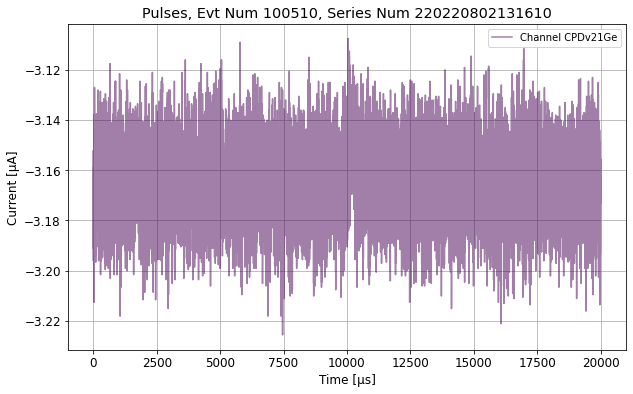

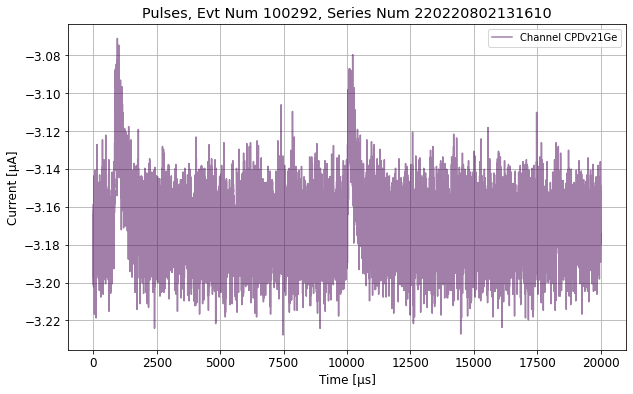

In [25]:
#checking lower and upper distribution traces

lower_rands = getrandevents(trigger_path,
    df.eventnumber,
    df.seriesnumber,                    
    ntraces=1000,
    nplot=1,
    channels=['CPDv21Ge'],
    cut=cmask_nochi2&ctemp_low,
    lgcplot=True)

upper_rands = getrandevents(trigger_path,
    df.eventnumber,
    df.seriesnumber,                       
    ntraces=1000,
    nplot=1,
    channels=['CPDv21Ge'],
    cut=cmask_nochi2&ctemp_loose&ctemp_up,
    lgcplot=True)
'''
mid_rands = getrandevents(trigger_path,
    df.eventnumber,
    df.seriesnumber,                       
    ntraces=1000,
    nplot=1,
    channels=['CPDv21Ge'],
    cut=ctrigger & ctemp_mid & cgood_time & cbaseline1,
    lgcplot=True)
''';    

Text(0.5, 1.0, 'lower low pass filtered pulses')

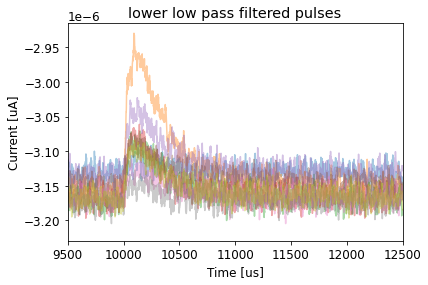

In [26]:
t_up = upper_rands[0]
x_up = upper_rands[1]
cout_upper = upper_rands[2]
lowpassed_upper = qp.utils.lowpassfilter(x_up)

t_low = lower_rands[0]
x_low = lower_rands[1]
cout_lower = lower_rands[2]
lowpassed_lower = qp.utils.lowpassfilter(x_low)
'''
t_mid = mid_rands[0]
x_mid = mid_rands[1]
cout_mid = mid_rands[2]
lowpassed_mid = qp.utils.lowpassfilter(x_mid)
''';
for xx in lowpassed_lower[1:10,0]:
    plt.plot(t_low*1e6, xx, alpha=0.4)
# plt.plot(t1*1e6, lowpassed_lower[5,0])
plt.xlim(9500, 12500)
plt.xlabel('Time [us]')
plt.ylabel('Current [uA]')
plt.title('lower low pass filtered pulses')


In [27]:
#upper only also do for lower
#norm -> avg 
#.roll -> temp defn then /= np.max() 
x_temp_up = np.zeros(x_up.shape)
for ii in range(x_up.shape[0]):
    ts = np.roll(x_up[ii,0],-int(df.oft0_constrained_CPDv21Ge[cout_upper].iloc[ii]*fs))
    #print(int(df.oft0_constrained_CPDv21Ge[cout_upper].iloc[ii]*fs))
    ts-= np.mean(ts[0:6000])
    x_temp_up[ii] = ts/ts.max()

x_avg_up = np.mean(x_temp_up, axis = 0) 


In [196]:
#just averaging without time shifting 
for ii in range(x_up.shape[0]):
    ts = x_up[ii,0]
    ts-= np.mean(ts[0:6000])
    x_temp_up[ii] = ts/ts.max()

x_avg_up_noroll = np.mean(x_temp_up, axis = 0) 

Text(0.5, 1.0, 'upper 1000 averaged normalized traces')

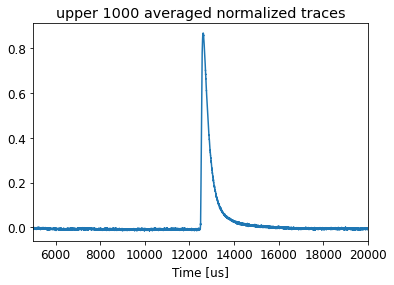

In [247]:
plt.plot(x_avg_up[0])
#plt.plot(x_avg_up_noroll[0])
plt.xlim(0.5e4, 2e4)
plt.xlabel('Time [us]')
#plt.ylabel('Current [uA]')
plt.title('upper 1000 averaged normalized traces')

In [28]:
#averaging and time shifting lower
x_temp_low = np.zeros(x_low.shape)
for ii in range(x_low.shape[0]):
    ts = np.roll(x_low[ii,0],-int(df.oft0_constrained_CPDv21Ge[cout_lower].iloc[ii]*fs))
    ts-= np.mean(ts[0:6000])
    x_temp_low[ii] = ts/ts.max()

x_avg_low = np.mean(x_temp_low, axis = 0) 

Text(0.5, 1.0, 'lower 1000 averaged normalized traces')

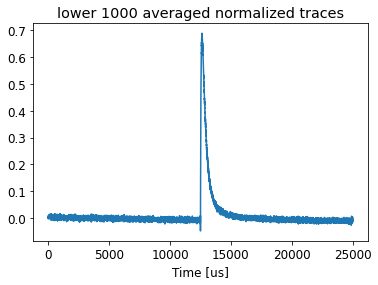

In [249]:
plt.plot(x_avg_low[0])
plt.xlabel('Time [us]')
#plt.ylabel('Current [uA]')
plt.title('lower 1000 averaged normalized traces')

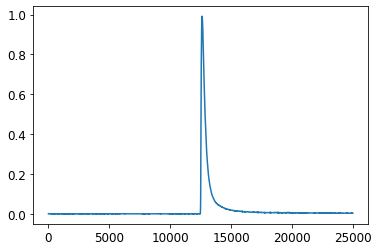

In [25]:
x_temp_mid = np.zeros(x_mid.shape)
for ii in range(x_mid.shape[0]):
    ts = np.roll(x_mid[ii,0],-int(df.oft0_constrained_CPDv21Ge[cout_mid].iloc[ii]*fs))
    #print(int(df.oft0_constrained_CPDv21Ge[cout_upper].iloc[ii]*fs))
    ts-= np.mean(ts[0:6000])
    x_temp_mid[ii] = ts/ts.max()

x_avg_mid = np.mean(x_temp_mid, axis = 0) 

plt.plot(x_avg_mid[0])

In [19]:
with open(yaml_path) as f:
    yaml_dict = yaml.load(f)
NLIN = (qp.OFnonlin(np.loadtxt
                (yaml_dict['CPDv21Ge']
                ['psd_path']) * 1e-20, 1.25e6)
       )

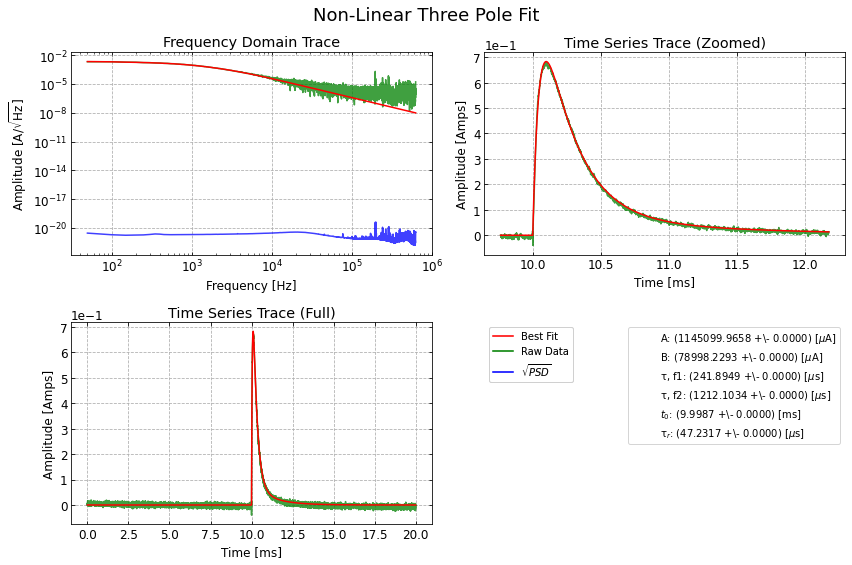

In [29]:
#three pole fit for template of the lower cuts

#returns amplitude or pulse height, rise time, fall time, time offset 
low_gooda, low_goodb, low_goodrise, low_goodf1, low_goodf2, low_tao = (NLIN.fit_falltimes(
    x_avg_low[0], npolefit=3, guess=(1, 0.5, 10e-6, 60e-6, 1000e-6, 10e-3), lgcplot=True)
                                                                      )

In [30]:
print(low_gooda, low_goodb, low_goodrise, low_goodf1, low_goodf2, low_tao)

1.145099965782395 0.0789982292794696 4.7231692226532594e-05 0.0002418949290760489 0.0012121034178373645 0.00999869059986125


array([2.19731564e+00, 1.29734668e-01, 5.41345747e-05, 1.73259179e-04,
       1.00682277e-03, 1.00042246e-02])

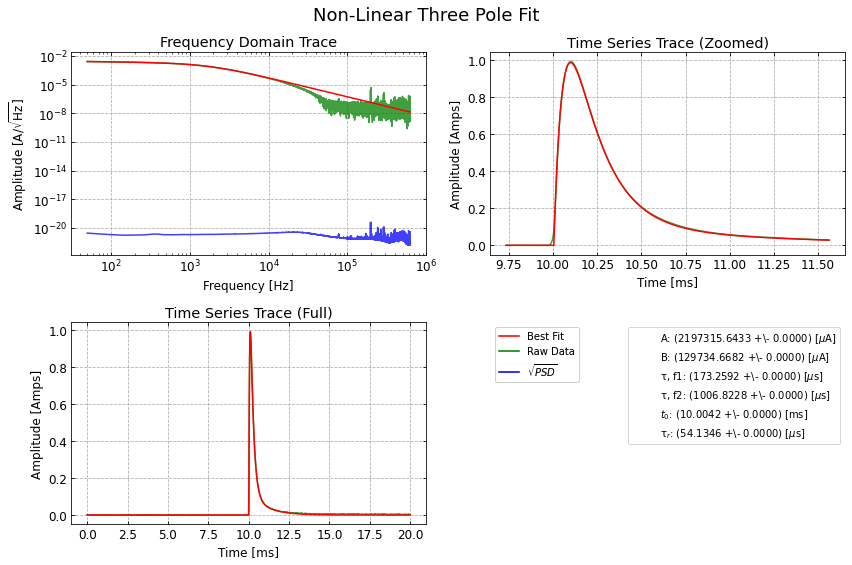

In [28]:
#three pole fit for template of the middle cut

#returns amplitude or pulse height, rise time, fall time, time offset 
NLIN.fit_falltimes(x_avg_mid[0], npolefit=3, guess=(3, 1, 10e-6, 180e-6, 2000e-6, 10e-3), lgcplot=True)

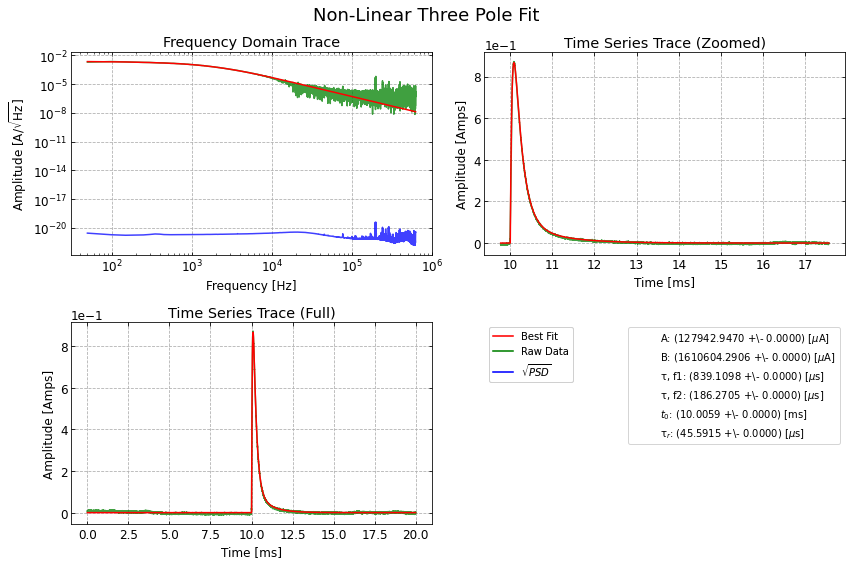

In [203]:
#three pole fit for template of the upper cuts
1, 0.5, 10e-6, 60e-6, 1000e-6, 10e-3
#returns amplitude or pulse height, rise time, fall time, time offset 
up_gooda, up_goodb, up_goodrise, up_goodf1, up_goodf2, up_tao=(NLIN.fit_falltimes(
    x_avg_up[0], npolefit=3, guess=(1, 0.5, 30e-6, 300e-6, 40e-6, 10e-3), lgcplot=True)
 )
#NLIN.fit_falltimes(x_avg[0], npolefit=4, guess=(2, 1, 0.5, 30e-6, 300e-6, 40e-6, 40e-6, 10e-3), lgcplot=True)

In [204]:
#templates for the upper and lower distribution of events created using fits which 
#had energy cutoffs 
lower_tempvf = NLIN.threepoletime(low_gooda, low_goodb, low_goodrise, low_goodf1, low_goodf2, low_tao)
upper_tempvf = NLIN.threepoletime(up_gooda, up_goodb, up_goodrise, up_goodf1, up_goodf2, up_tao)


In [208]:
#'''
np.savetxt("templatevf_lowvf_I2_D20220628_T132125.txt", lower_tempvf)
np.savetxt("templatevf_upvf_I2_D20220628_T132125.txt", upper_tempvf)
#''';

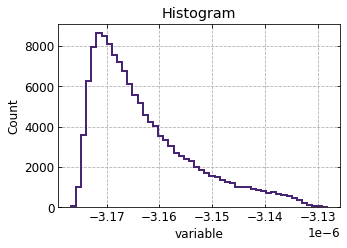

In [16]:

fig, ax = plt.subplots(figsize=np.array([1.5, 1]) * (3 + 3/8))
_, ax = dp.hist(
   df.baseline_CPDv21Ge,
#    xlims=(-4,-0),
#    ylims=(),
    ax=ax,
    nbins=50,
#     cmap='binary_r',
    cuts=[ctrigger&cgood_time&cbaseline1],
    lgcrawdata=False,
    lgclegend=False,
)
ax.set_yscale('linear')
ax.set_title('Baseline section')


39.82751844259718

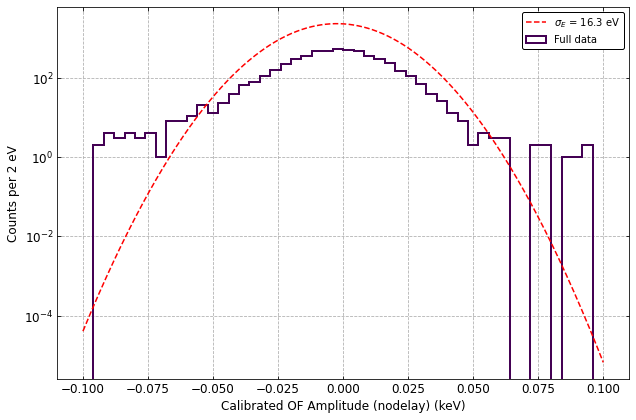

In [50]:
fig, ax = dp.hist(
    calibratedofamp_nodelay[crandoms&crandschisqared],
    nbins=50,
    xlims=(-0.1,0.1),
    labeldict = {'title' : None,
                'xlabel' : 'Calibrated OF Amplitude (nodelay) (keV)',
                'ylabel' : 'Counts per 2 eV',
                },
)
x_mean, x_std, _ = qp.cut.iterstat(calibratedofamp_nodelay[crandoms&crandschisqared])

xx = np.linspace(-0.10, 0.10, num=1000)

hist, bin_edges = np.histogram(calibratedofamp_nodelay, bins=50, range=(-.10, .10))
norm = hist.sum() * np.mean(np.diff(bin_edges))

yy = stats.norm.pdf(xx, scale=x_std, loc=x_mean) * norm

ax.plot(
    xx,
    yy,
    color='r',
    linestyle='dashed',
    label=r'$\sigma_E$' + f' = {x_std*1000:.1f} eV'
)

ax.legend(loc='upper right', framealpha=1, edgecolor='k')
fig.tight_layout()

np.std(calibratedofamp_nodelay)
#standard deviation of noise in calibrated OF amp, this is the baseline energy resolution
#we expect probably better than 20 eV



In [45]:
czerotenkev=dp.inrange(calibratedofamp,0,7)
ctenpluskev=dp.inrange(calibratedofamp,7,np.inf)
callev = dp.inrange(calibratedofamp, 0,np.inf)

In [52]:
cut_list = [cgood_time,cbaseline1,ctemp_low]
index_list = ['time','baseline','chi2 energy strict']
energy_list = [czerotenkev,ctenpluskev,callev]
cols_list = ['Randoms - Differential Efficiency','Randoms - Total Efficiency','Trigger (0-7keV) - Differential Efficiency','Trigger (0-7keV) - Total Efficiency','Trigger (7keV+) - Differential Efficiency','Trigger (7keV+) - Total Efficiency']
energy_range_list = ["0-7 keV","7-inf keV",'0-inf keV']

cutefficiencies(cut_list,index_list,energy_cut_array=energy_list,energy_ranges=energy_range_list)

,Randoms - Differential Efficiency,Randoms - Total Efficiency,Trigger (0-7 keV)- Differential Efficiency,Trigger (0-7 keV)- Total Efficiency,Trigger (7-inf keV)- Differential Efficiency,Trigger (7-inf keV)- Total Efficiency,Trigger (0-inf keV)- Differential Efficiency,Trigger (0-inf keV)- Total Efficiency
time,0.572500,0.572500,0.568150,0.568150,0.566211,0.566211,0.567510,0.567510
baseline,0.874505,0.500654,0.922964,0.524381,0.860583,0.487271,0.902446,0.512147
chi2 energy strict,0.944073,0.472654,0.905879,0.475026,0.172170,0.083893,0.675743,0.346080


In [53]:
randoms_total_eff_strict = 0.472654	

In [49]:
cut_list = [cgood_time,cbaseline1,ctemp_loose]
index_list = ['time','baseline','chi2 energy loose']
energy_list = [czerotenkev,ctenpluskev,callev]
cols_list = ['Randoms - Differential Efficiency','Randoms - Total Efficiency','Trigger (0-7keV) - Differential Efficiency','Trigger (0-7keV) - Total Efficiency','Trigger (7keV+) - Differential Efficiency','Trigger (7keV+) - Total Efficiency']
energy_range_list = ["0-7 keV","7-inf keV",'0-inf keV']

cutefficiencies(cut_list,index_list,energy_cut_array=energy_list,energy_ranges=energy_range_list)

,Randoms - Differential Efficiency,Randoms - Total Efficiency,Trigger (0-7 keV)- Differential Efficiency,Trigger (0-7 keV)- Total Efficiency,Trigger (7-inf keV)- Differential Efficiency,Trigger (7-inf keV)- Total Efficiency,Trigger (0-inf keV)- Differential Efficiency,Trigger (0-inf keV)- Total Efficiency
time,0.572500,0.572500,0.568150,0.568150,0.566211,0.566211,0.567510,0.567510
baseline,0.874505,0.500654,0.922964,0.524381,0.860583,0.487271,0.902446,0.512147
chi2 energy,0.987171,0.494231,0.997656,0.523152,0.733045,0.357192,0.914658,0.468439


In [55]:
randoms_total_eff = 0.494231
calc_rate_all = sum(cgood_time&cbaseline1&ctemp_loose)/tot_time
true_rate_all = calc_rate_all/randoms_total_eff
calc_rate_zeroseven = sum(cgood_time&cbaseline1&ctemp_loose&czerotenkev)/tot_time
true_rate_zeroseven = calc_rate_zeroseven/randoms_total_eff
calc_rate_sevenplus = sum(cgood_time&cbaseline1&ctemp_loose&ctenpluskev)/tot_time
true_rate_sevenplus = calc_rate_sevenplus/randoms_total_eff

calc_rate_strict_zeroseven = sum(cgood_time&cbaseline1&ctemp_low&czerotenkev)/tot_time
true_rate_strict_zeroseven = calc_rate_strict_zeroseven/randoms_total_eff_strict

print(f'(loosechi2) The calculated rate from 0-inf keV is {calc_rate_all}, the true rate is {true_rate_all}\n')
print(f'(loosechi2) The calculated rate from 0-7 keV is {calc_rate_zeroseven}, the true rate is {true_rate_zeroseven}\n')
print(f'(loosechi2) The calculated rate from 7-inf keV is {calc_rate_sevenplus}, the true rate is {true_rate_sevenplus}\n')
print(f'(strictchi2) The calculated rate from 0-7 keV is {calc_rate_strict_zeroseven}, the true rate is {true_rate_strict_zeroseven}\n')



(loosechi2) The calculated rate from 0-inf keV is 9.346497989767478, the true rate is 18.91119332815521

(loosechi2) The calculated rate from 0-7 keV is 6.900045957265776, the true rate is 13.961175962790227

(loosechi2) The calculated rate from 7-inf keV is 2.161397824307853, the true rate is 4.373254256224019

(strictchi2) The calculated rate from 0-7 keV is 6.301707697105049, the true rate is 13.33260206642713



In [47]:
def cutefficiencies(cut_array,cut_index,energy_cut_array=None,columns=None,basecut=None,energy_ranges=None):
    if basecut == None:
        basecut=dp.inrange(calibratedofamp,-np.inf,np.inf)
    
    if columns == None:
        columns=['Randoms - Differential Efficiency','Randoms - Total Efficiency']
        if energy_cut_array == None:
            columns.append('Trigger - Differential Efficiency')
            columns.append('Trigger - Total Efficiency')
        else:
            if energy_ranges == None:
                for count, energycut in enumerate(energy_cut_array):
                    columns.append(f'Trigger - Differential Efficiency - range {count+1}')
                    columns.append(f'Trigger - Total Efficiency - range {count+1}')
            else: 
                if len(energy_cut_array) != len(energy_ranges):
                    return "Error - energy_range and energy_cut_array length do not match"
                else:
                    for count, e_range in enumerate(energy_ranges):
                        columns.append(f'Trigger ({e_range})- Differential Efficiency')
                        columns.append(f'Trigger ({e_range})- Total Efficiency')
    
    eff_array=[]
    
    for count, cut in enumerate(cut_array):
        cut_random_diff=sum(cut&basecut&crandoms)/sum(crandoms&basecut)
        cut_random_tot=sum(cut&basecut&crandoms)/sum(crandoms)
        cut_ind=[cut_random_diff,cut_random_tot]
        if energy_cut_array == None:
            cut_trigger_diff=sum(cut&basecut&ctrigger)/sum(ctrigger&basecut)
            cut_trigger_tot=sum(cut&basecut&ctrigger)/sum(ctrigger)
            cut_ind.append(cut_trigger_diff)
            cut_ind.append(cut_trigger_tot)
        else:
            for n, energycut in enumerate(energy_cut_array):
                cut_trigger_diff=sum(cut&basecut&ctrigger&energycut)/sum(ctrigger&basecut&energycut)
                cut_trigger_tot=sum(cut&basecut&ctrigger&energycut)/sum(ctrigger&energycut)
                cut_ind.append(cut_trigger_diff)
                cut_ind.append(cut_trigger_tot)
        eff_array.append(cut_ind)
        basecut=basecut&cut
    cut_table=pd.DataFrame(eff_array,
                           columns=columns,
                           index=cut_index)
    return cut_table.head()

In [66]:
fig, ax = plt.subplots(figsize=np.array([1.5, 1]) * (3 + 3/8))
bins=100
_, ax = dp.hist(
   calibratedofamp,
 #   xlims=(0, 2),
    ax=ax,
    nbins=100,
#     cmap='binary_r',
    cuts=[ctrigger, cgood_time, cbaseline1, ctemp_loose],
    lgcrawdata=False,
    labeldict = {'title' : 'Efficiencies, loose chi2',
                'xlabel' : 'Calibrated OF Amplitude (uncon) (keV)',
                'ylabel' : (f'Counts per {int((bins[1] - bins[0]) / nbins)} eV')
                 
                 

SyntaxError: invalid syntax (<ipython-input-66-7085f8b92542>, line 14)

In [74]:
#parameters used for creation of the lowtempv4 template that this data was processed with
#template6sigmav6_I2_D20220628_T210658.txt
#templatev3_lowv2_6sigmav4_I2_D20220628_T210658.txt
lower_a = 1.05157111
lower_b = 2.94381068e-01
lower_fall1 = 3.07174112e-04
lower_fall2 = 2.29872679e-05
lower_rise = 3.51094660e-05
lower_tao = 1.00002203e-02
'''
If False, only the best fit parameters are returned. If
    True, the errors in the fit parameters, the covariance
    matrix, and chi squared statistic are returned as well.
''';

(array([6.69031869e-01, 1.28626382e-01, 1.00437920e-04, 1.00495605e-04,
        1.00139630e-04, 9.98881977e-03]),
 array([2.88464951e-20, 5.09523148e-20, 6.36057279e-17, 6.35535629e-17,
        6.38777801e-17, 9.00168450e-17]),
 array([[ 8.32120279e-40, -4.99202849e-40, -6.23167572e-37,
         -6.22654446e-37, -6.25838727e-37, -5.03684835e-37],
        [-4.32636125e-39,  2.59613838e-39,  3.24083871e-36,
          3.23817250e-36,  3.25471811e-36,  2.61503148e-36],
        [-5.39647115e-36,  3.24083869e-36,  4.04568862e-33,
          4.04236964e-33,  4.06296618e-33,  3.24788697e-33],
        [-5.39128486e-36,  3.23817247e-36,  4.04236964e-33,
          4.03905535e-33,  4.05962277e-33,  3.24231486e-33],
        [-5.42346304e-36,  3.25471808e-36,  4.06296618e-33,
          4.05962277e-33,  4.08037080e-33,  3.27686942e-33],
        [-5.76588015e-36,  2.61503101e-36,  3.24788624e-33,
          3.24231413e-33,  3.27686869e-33,  8.10303239e-33]]),
 1.4188069696880204e+20,
 True)

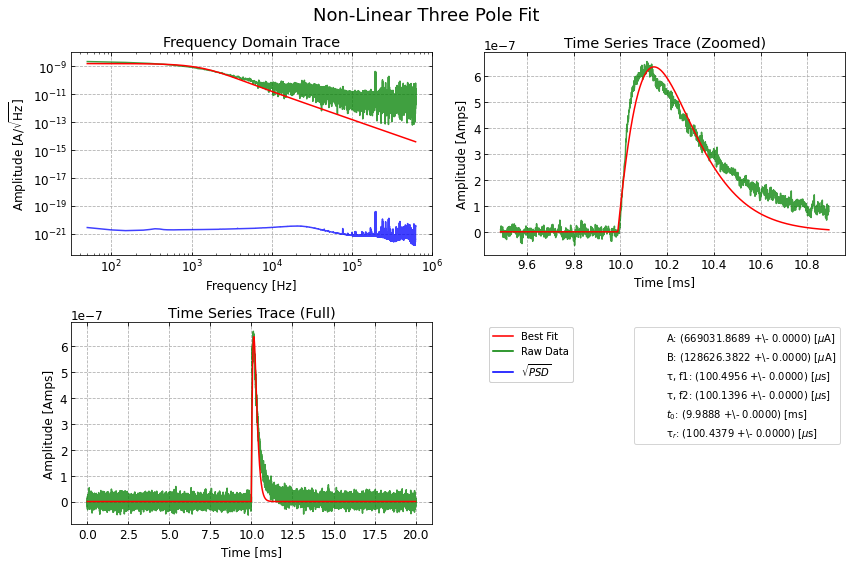

In [97]:
NLIN.fit_falltimes(x_low[0,0], npolefit=3, errscale=1, guess=(lower_a, lower_b, 
                    lower_rise, lower_fall1, lower_fall2, lower_tao), lgcplot=True, lgcfullrtn=True)

(array([6.71633361e-01, 1.28614157e-01, 1.00385107e-04, 1.00437919e-04,
        1.00110933e-04, 9.98338125e-03]),
 array([2.69114110e-21, 6.51670091e-20, 7.51463858e-17, 7.50869649e-17,
        7.54573346e-17, 8.64721872e-17]),
 array([[ 7.24224042e-42, -8.13544888e-40, -9.38124963e-37,
         -9.37381753e-37, -9.42008869e-37, -6.14494357e-37],
        [-3.79046812e-41,  4.24673908e-39,  4.89705814e-36,
          4.89318034e-36,  4.91732296e-36,  3.20434899e-36],
        [-4.39694940e-38,  4.89705843e-36,  5.64697929e-33,
          5.64251305e-33,  5.67031931e-33,  3.68634332e-33],
        [-4.40159229e-38,  4.89318063e-36,  5.64251305e-33,
          5.63805230e-33,  5.66582433e-33,  3.68070903e-33],
        [-4.37275037e-38,  4.91732325e-36,  5.67031931e-33,
          5.66582433e-33,  5.69380935e-33,  3.71576591e-33],
        [ 1.22797510e-37,  3.20434927e-36,  3.68634335e-33,
          3.68070906e-33,  3.71576594e-33,  7.47743916e-33]]),
 1.1480835783457276e+20,
 True)

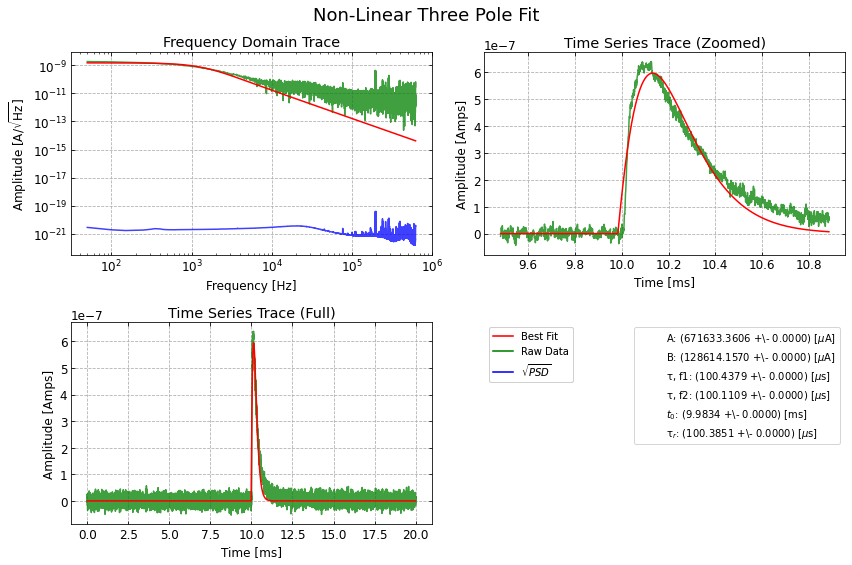

In [98]:
NLIN.fit_falltimes(x_low[1,0], npolefit=3, errscale=1, guess=(lower_a, lower_b, 
                    lower_rise, lower_fall1, lower_fall2, lower_tao), lgcplot=True, lgcfullrtn=True)

(array([6.70790660e-01, 1.29318588e-01, 1.00397608e-04, 1.00461485e-04,
        1.00068353e-04, 9.98333630e-03]),
 array([4.25738696e-21, 3.72712284e-20, 5.17603806e-17, 5.17138086e-17,
        5.20027018e-17, 7.79780405e-17]),
 array([[ 1.81253437e-41, -2.67842977e-40, -3.71962644e-37,
         -3.71626521e-37, -3.73707756e-37, -3.19700570e-37],
        [-9.40763602e-41,  1.38914446e-39,  1.92916151e-36,
          1.92742024e-36,  1.93820203e-36,  1.65458902e-36],
        [-1.30869570e-37,  1.92916275e-36,  2.67913700e-33,
          2.67672556e-33,  2.69165698e-33,  2.28680367e-33],
        [-1.30798808e-37,  1.92742148e-36,  2.67672556e-33,
          2.67431800e-33,  2.68922550e-33,  2.28239230e-33],
        [-1.31237384e-37,  1.93820327e-36,  2.69165698e-33,
          2.68922550e-33,  2.70428099e-33,  2.30968584e-33],
        [-2.91268662e-38,  1.65459053e-36,  2.28680368e-33,
          2.28239231e-33,  2.30968585e-33,  6.08057479e-33]]),
 1.556213467001043e+20,
 True)

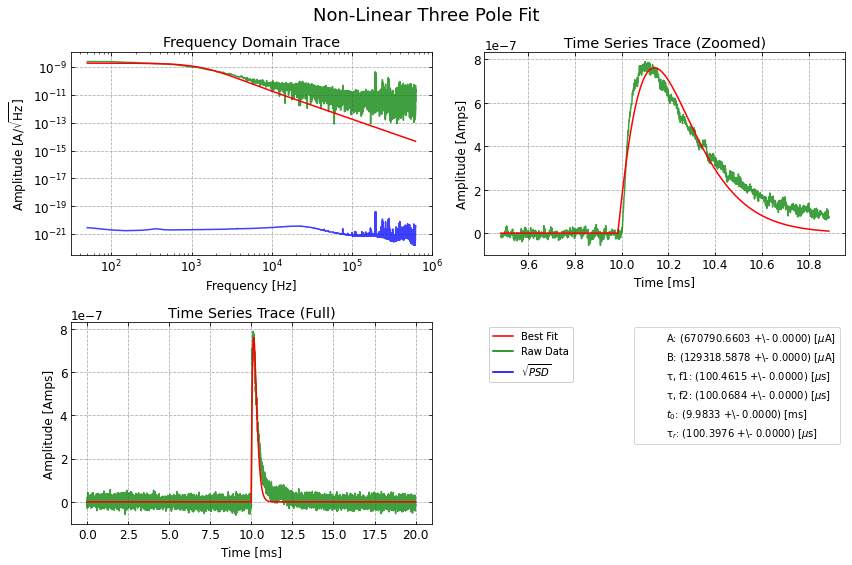

In [99]:
NLIN.fit_falltimes(x_low[2,0], npolefit=3, errscale=1, guess=(lower_a, lower_b, 
                    lower_rise, lower_fall1, lower_fall2, lower_tao), lgcplot=True, lgcfullrtn=True)

(array([6.70856093e-01, 1.29224999e-01, 1.00409414e-04, 1.00466029e-04,
        1.00117145e-04, 9.98349273e-03]),
 array([2.69399019e-20, 5.34056311e-20, 6.58106829e-17, 6.57581511e-17,
        6.60841408e-17, 9.86404151e-17]),
 array([[ 7.25758315e-40, -5.49467642e-40, -6.77092017e-37,
         -6.76549431e-37, -6.79911091e-37, -5.78664497e-37],
        [-3.76608786e-39,  2.85216143e-39,  3.51464446e-36,
          3.51183084e-36,  3.52926295e-36,  2.99811937e-36],
        [-4.63745677e-36,  3.51464375e-36,  4.33104599e-33,
          4.32758776e-33,  4.34901373e-33,  3.67810330e-33],
        [-4.63305353e-36,  3.51183014e-36,  4.32758776e-33,
          4.32413444e-33,  4.34553004e-33,  3.67182146e-33],
        [-4.66032880e-36,  3.52926224e-36,  4.34901372e-33,
          4.34553003e-33,  4.36711366e-33,  3.71071463e-33],
        [-5.32039839e-36,  2.99811815e-36,  3.67810272e-33,
          3.67182087e-33,  3.71071404e-33,  9.72993149e-33]]),
 1.2510263734834448e+20,
 True)

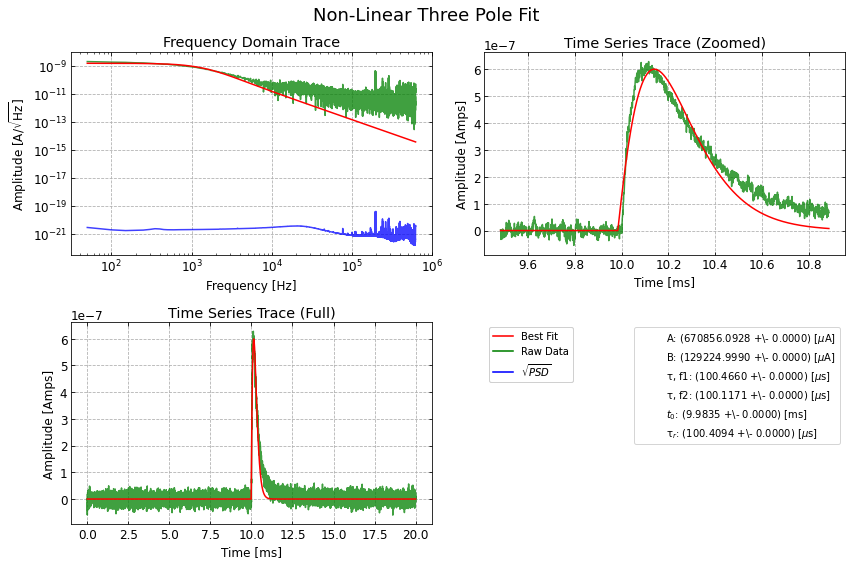

In [100]:
NLIN.fit_falltimes(x_low[5,0], npolefit=3, errscale=1, guess=(lower_a, lower_b, 
                    lower_rise, lower_fall1, lower_fall2, lower_tao), lgcplot=True, lgcfullrtn=True)

(array([6.68971388e-01, 1.27376878e-01, 1.00446462e-04, 1.00506738e-04,
        1.00131886e-04, 9.98848574e-03]),
 array([8.10678730e-21, 4.43134021e-20, 5.77932994e-17, 5.77432745e-17,
        5.80567341e-17, 7.75805593e-17]),
 array([[ 6.57200003e-41, -3.73975061e-40, -4.87732603e-37,
         -4.87309005e-37, -4.89959218e-37, -3.73499267e-37],
        [-3.45091394e-40,  1.96367760e-39,  2.56100676e-36,
          2.55878430e-36,  2.57268898e-36,  1.95803362e-36],
        [-4.50088617e-37,  2.56100682e-36,  3.34006546e-33,
          3.33717350e-33,  3.35526689e-33,  2.54303315e-33],
        [-4.49703290e-37,  2.55878436e-36,  3.33717350e-33,
          3.33428576e-33,  3.35235284e-33,  2.53851798e-33],
        [-4.52114110e-37,  2.57268904e-36,  3.35526689e-33,
          3.35235284e-33,  3.37058438e-33,  2.56674628e-33],
        [-3.34827190e-37,  1.95803368e-36,  2.54303315e-33,
          2.53851798e-33,  2.56674628e-33,  6.01874318e-33]]),
 1.5176031181328777e+20,
 True)

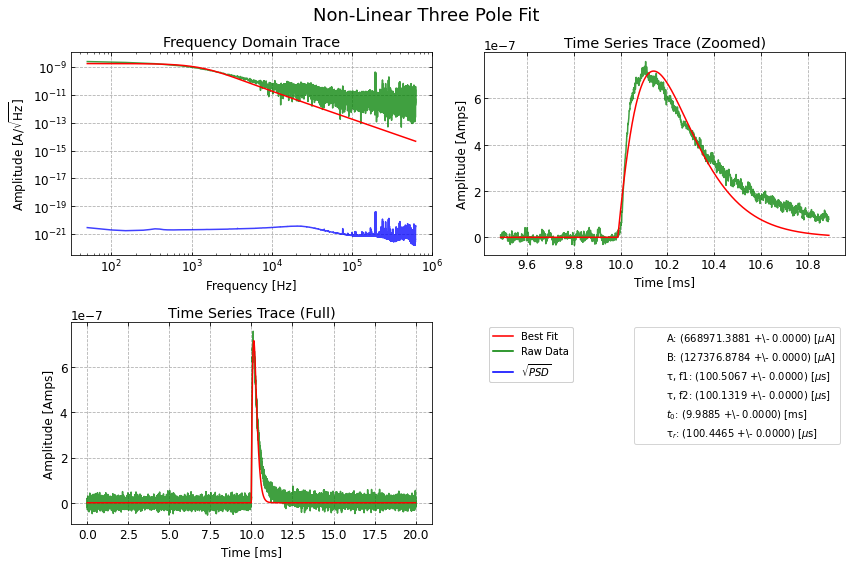

In [101]:
NLIN.fit_falltimes(x_low[10,0], npolefit=3, errscale=1, guess=(lower_a, lower_b, 
                    lower_rise, lower_fall1, lower_fall2, lower_tao), lgcplot=True, lgcfullrtn=True)

/home/maggie_reed/.local/lib/python3.6/site-packages/qetpy/core/_fitting.py:2362: RuntimeWarning: invalid value encountered in sqrt
  errors = np.sqrt(cov.diagonal())


(array([6.71242073e-01, 1.28992127e-01, 1.00404107e-04, 1.00460273e-04,
        1.00113562e-04, 9.98338300e-03]),
 array([           nan, 5.47021999e-20, 6.67941235e-17, 6.67396567e-17,
        6.70782378e-17, 8.56743180e-17]),
 array([[-1.32105431e-40, -5.75168404e-40, -7.02304887e-37,
         -7.01730459e-37, -7.05296422e-37, -5.13988758e-37],
        [ 6.87027801e-40,  2.99233067e-39,  3.65377152e-36,
          3.65078499e-36,  3.66932493e-36,  2.67042520e-36],
        [ 8.37972327e-37,  3.65377055e-36,  4.46145494e-33,
          4.45781592e-33,  4.48040647e-33,  3.24764818e-33],
        [ 8.37098660e-37,  3.65078402e-36,  4.45781592e-33,
          4.45418178e-33,  4.47674209e-33,  3.24231305e-33],
        [ 8.42520706e-37,  3.66932396e-36,  4.48040647e-33,
          4.47674209e-33,  4.49948998e-33,  3.27541074e-33],
        [ 9.62108569e-37,  2.67042431e-36,  3.24764822e-33,
          3.24231309e-33,  3.27541078e-33,  7.34008877e-33]]),
 1.2401180223962243e+20,
 True)

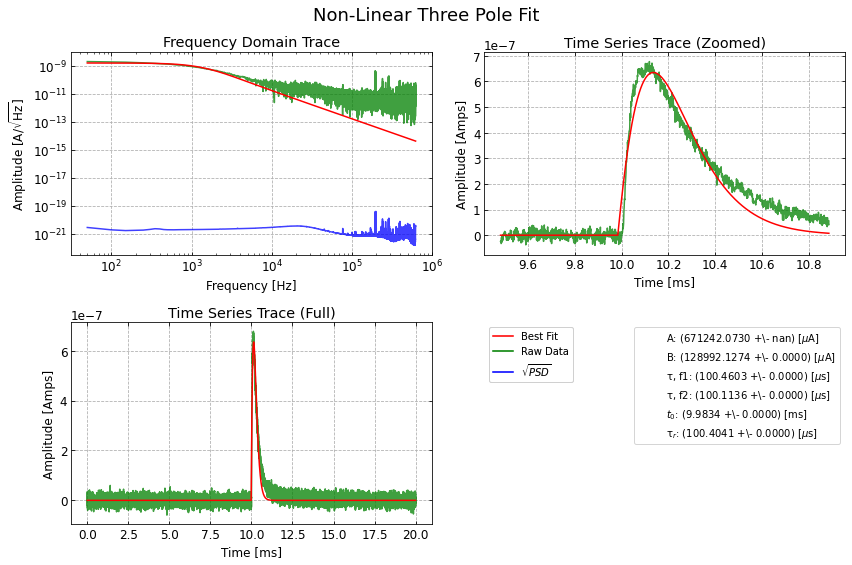

In [102]:
NLIN.fit_falltimes(x_low[100,0], npolefit=3, errscale=1, guess=(lower_a, lower_b, 
                    lower_rise, lower_fall1, lower_fall2, lower_tao), lgcplot=True, lgcfullrtn=True)

/home/maggie_reed/.local/lib/python3.6/site-packages/qetpy/core/_fitting.py:2362: RuntimeWarning: invalid value encountered in sqrt
  errors = np.sqrt(cov.diagonal())


(array([6.71031214e-01, 1.29285044e-01, 1.00413172e-04, 1.00469355e-04,
        1.00123225e-04, 9.98344004e-03]),
 array([           nan, 5.46998984e-20, 6.68739477e-17, 6.68203246e-17,
        6.71529805e-17, 9.28951249e-17]),
 array([[-3.46587332e-40, -5.76565413e-40, -7.04880899e-37,
         -7.04313745e-37, -7.07826968e-37, -5.58460735e-37],
        [ 1.79796766e-39,  2.99207888e-39,  3.65798218e-36,
          3.65504133e-36,  3.67325838e-36,  2.89352824e-36],
        [ 2.19603723e-36,  3.65798241e-36,  4.47212487e-33,
          4.46853787e-33,  4.49075759e-33,  3.52264130e-33],
        [ 2.19384681e-36,  3.65504156e-36,  4.46853787e-33,
          4.46495578e-33,  4.48714507e-33,  3.51677117e-33],
        [ 2.20741191e-36,  3.67325862e-36,  4.49075759e-33,
          4.48714506e-33,  4.50952280e-33,  3.55310904e-33],
        [ 2.55431493e-36,  2.89352854e-36,  3.52264131e-33,
          3.51677119e-33,  3.55310906e-33,  8.62950423e-33]]),
 1.2555906725701837e+20,
 True)

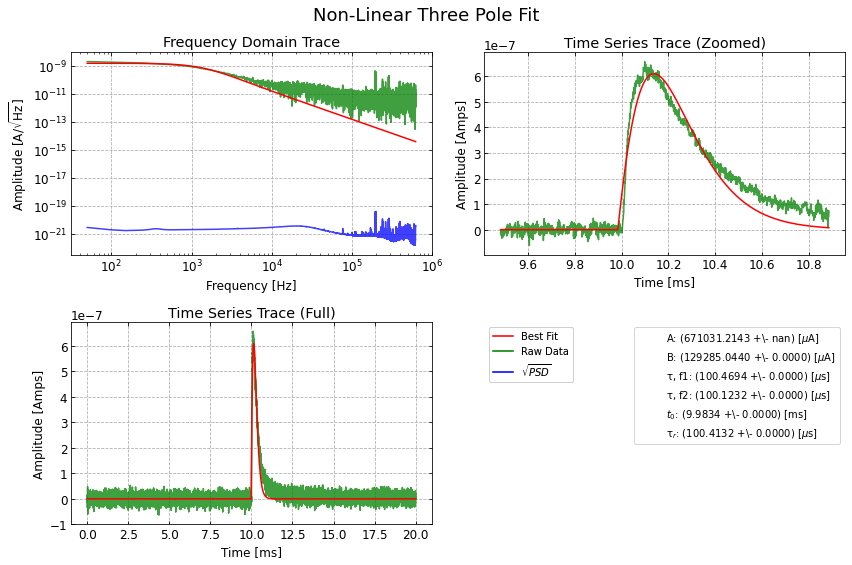

In [103]:
NLIN.fit_falltimes(x_low[500,0], npolefit=3, errscale=1, guess=(lower_a, lower_b, 
                    lower_rise, lower_fall1, lower_fall2, lower_tao), lgcplot=True, lgcfullrtn=True)

/home/maggie_reed/.local/lib/python3.6/site-packages/qetpy/core/_fitting.py:2362: RuntimeWarning: invalid value encountered in sqrt
  errors = np.sqrt(cov.diagonal())


(array([6.71687027e-01, 1.28766312e-01, 1.00369112e-04, 1.00419002e-04,
        1.00110341e-04, 9.98348629e-03]),
 array([           nan, 7.73755272e-20, 8.42742828e-17, 8.42100639e-17,
        8.46098997e-17, 9.13961988e-17]),
 array([[-8.62925474e-40, -1.14825653e-39, -1.25063172e-36,
         -1.24967710e-36, -1.25561465e-36, -7.72362436e-37],
        [ 4.49871926e-39,  5.98697220e-39,  6.52075933e-36,
          6.51578381e-36,  6.54673068e-36,  4.02357869e-36],
        [ 4.89823539e-36,  6.52075714e-36,  7.10215474e-33,
          7.09674168e-33,  7.13040998e-33,  4.37220586e-33],
        [ 4.89403629e-36,  6.51578161e-36,  7.09674168e-33,
          7.09133486e-33,  7.12496435e-33,  4.36591635e-33],
        [ 4.92015047e-36,  6.54672848e-36,  7.13040998e-33,
          7.12496435e-33,  7.15883513e-33,  4.40501389e-33],
        [ 3.90633275e-36,  4.02357711e-36,  4.37220590e-33,
          4.36591639e-33,  4.40501394e-33,  8.35326515e-33]]),
 1.1716640606334294e+20,
 True)

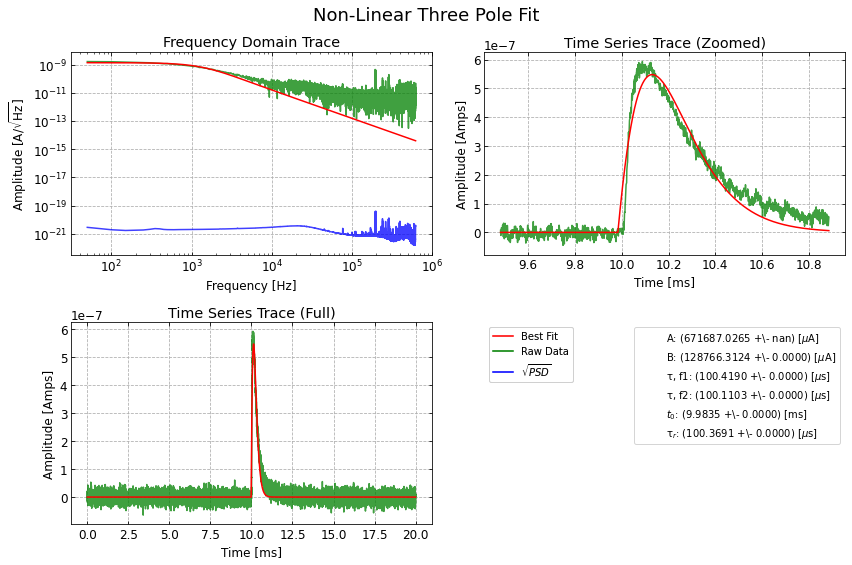

In [111]:
NLIN.fit_falltimes(x_low[300,0], npolefit=3, errscale=1, guess=(lower_a, lower_b, 
                    lower_rise, lower_fall1, lower_fall2, lower_tao), lgcplot=True, lgcfullrtn=True)

(array([6.62614707e-01, 1.51438526e-01, 9.97290440e-05, 9.97288801e-05,
        9.97312779e-05, 1.00088208e-02]),
 array([1.64384386e-24, 1.33466021e-23, 7.73542551e-19, 4.97523786e-18,
        1.76110526e-17, 2.81784535e-17]),
 array([[ 2.70222264e-48, -1.30865722e-47, -1.47489306e-43,
         -9.49602119e-43,  3.36216979e-42, -2.40318999e-41],
        [-3.65229196e-47,  1.78131788e-46,  1.91072024e-42,
          1.23027438e-41, -4.35597663e-41,  3.25315553e-40],
        [-1.93788052e-42,  1.91071801e-42,  5.98368078e-37,
          3.84855810e-36, -1.36228981e-35,  1.42377156e-35],
        [-1.24663493e-41,  1.23027294e-41,  3.84855810e-36,
          2.47529917e-35, -8.76191755e-35,  9.15954163e-35],
        [ 4.41296277e-41, -4.35597155e-41, -1.36228981e-35,
         -8.76191755e-35,  3.10149174e-34, -3.24242320e-34],
        [-9.54577459e-41,  3.25315411e-40,  1.42377156e-35,
          9.15954163e-35, -3.24242320e-34,  7.94025239e-34]]),
 1.2494973901386031e+20,
 False)

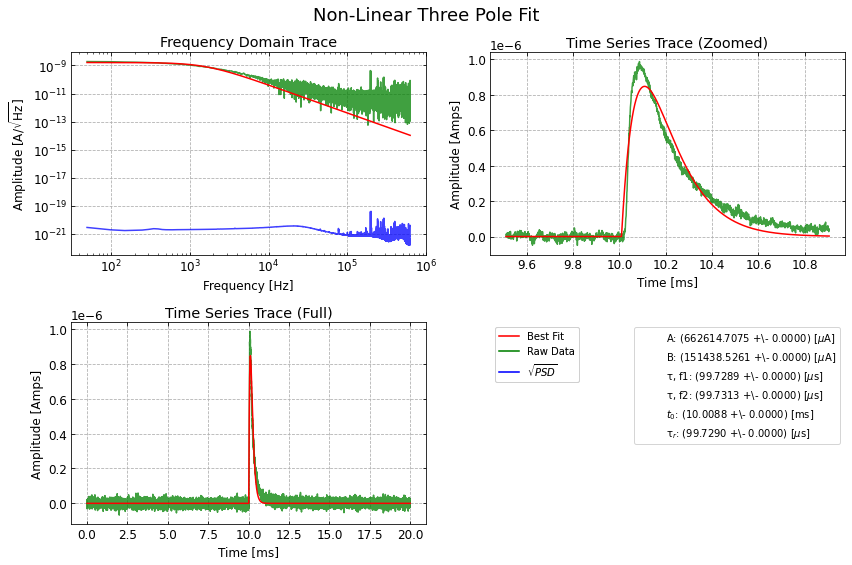

In [115]:
#Ok now trying to see if this is a good fit for the upper traces too
NLIN.fit_falltimes(x_up[10,0], npolefit=3, errscale=1, guess=(lower_a, lower_b, 
                    lower_rise, lower_fall1, lower_fall2, lower_tao), lgcplot=True, lgcfullrtn=True)

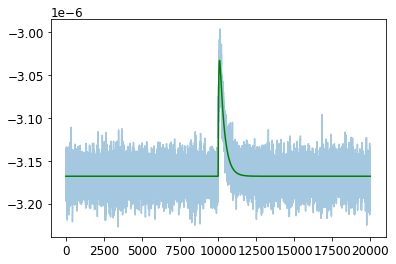

In [211]:
#plotting the template used to process vs the lower distribution trace
trace_number=5
plt.plot(t_low*1e6, x_low[trace_number,0], alpha=0.4)

templaterolled_low = np.roll(template,int(
    df.oft0_unconstrained_CPDv21Ge[cout_lower].iloc[trace_number]*fs))
plt.plot(t_low*1e6, (templaterolled_low*
    df.ofamp_unconstrained_CPDv21Ge[cout_lower].iloc[trace_number])+
    df.baseline_CPDv21Ge[cout_lower].iloc[trace_number],color='green')

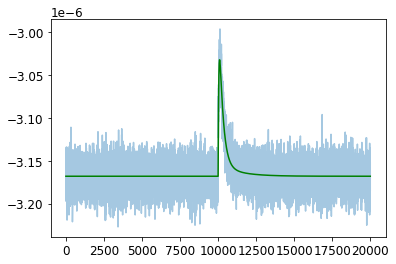

In [210]:
#plotting the good template with energy selection vs a lower trace
plt.plot(t_low*1e6, x_low[trace_number,0], alpha=0.4)
goodtemproll_low = np.roll(goodtemp_low,int(
    df.oft0_unconstrained_CPDv21Ge[cout_lower].iloc[trace_number]*fs))
plt.plot(t_low*1e6, (goodtemproll_low*
    df.ofamp_unconstrained_CPDv21Ge[cout_lower].iloc[trace_number])+
    df.baseline_CPDv21Ge[cout_lower].iloc[trace_number],color='green')

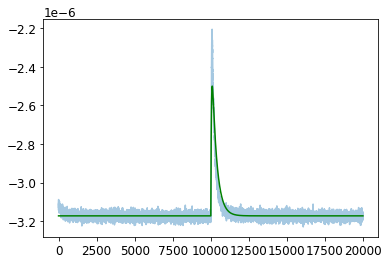

In [159]:
trace_number=500
plt.plot(t_up*1e6, x_up[trace_number,0], alpha=0.4)
#df.baseline_CPDv21Ge[cout_upper].iloc[trace_number]
templaterolled_up = np.roll(template,int(
    df.oft0_unconstrained_CPDv21Ge[cout_upper].iloc[trace_number]*fs))
plt.plot(t_up*1e6, (templaterolled_up*
    df.ofamp_unconstrained_CPDv21Ge[cout_upper].iloc[trace_number]
                    +df.baseline_CPDv21Ge[cout_upper].iloc[trace_number])
    ,color='green')
#plt.plot(t_low*1e6, x_low[trace_number,0], alpha=0.4)

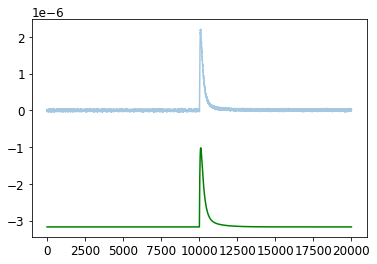

In [213]:
#plotting a template in the upper part vs the good template with energy selection
trace_number=500
plt.plot(t_up*1e6, x_up[trace_number,0], alpha=0.4)
#df.baseline_CPDv21Ge[cout_upper].iloc[trace_number]
goodtemproll_up = np.roll(goodtemp_up,int(
    df.oft0_unconstrained_CPDv21Ge[cout_upper].iloc[trace_number]*fs))
plt.plot(t_up*1e6, (goodtemproll_up*
    df.ofamp_unconstrained_CPDv21Ge[cout_upper].iloc[trace_number]
                    +df.baseline_CPDv21Ge[cout_upper].iloc[trace_number])
    ,color='green')

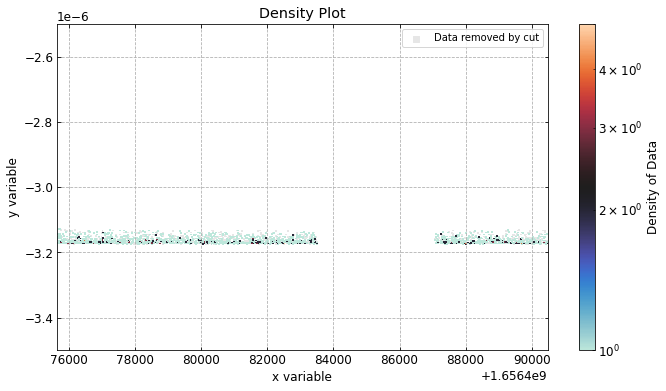

In [153]:
fig, ax = dp.densityplot(
    df.eventtime,
    df.baseline_CPDv21Ge,
    cut=ctrigger&cgood_time&ctemp_tenfifteenkev&cbaseline1&ctemp_low,
    ylims=[-3.5e-6, -2.5e-6],
 #   xlims=[0, 40],
    plot_cut_data = True,
    basecut = ctrigger&cgood_time&ctemp_tenfifteenkev&cbaseline1,
)

# cut effic. function

In [52]:
def cutefficiencies(cut_array,cut_index, suffix, energy_cut_array=None,columns=None,basecut=None,energy_ranges=None):
    calibratedofamp = suffix
    if basecut == None:
        basecut=dp.inrange(calibratedofamp,-np.inf,np.inf)
    
    if columns == None:
        columns=['Randoms - Differential Efficiency','Randoms - Total Efficiency']
        if energy_cut_array == None:
            columns.append('Trigger - Differential Efficiency')
            columns.append('Trigger - Total Efficiency')
        else:
            if energy_ranges == None:
                for count, energycut in enumerate(energy_cut_array):
                    columns.append(f'Trigger - Differential Efficiency - range {count+1}')
                    columns.append(f'Trigger - Total Efficiency - range {count+1}')
            else: 
                if len(energy_cut_array) != len(energy_ranges):
                    return "Error - energy_range and energy_cut_array length do not match"
                else:
                    for count, e_range in enumerate(energy_ranges):
                        columns.append(f'Trigger ({e_range})- Differential Efficiency')
                        columns.append(f'Trigger ({e_range})- Total Efficiency')
    
    eff_array=[]
    
    for count, cut in enumerate(cut_array):
        cut_random_diff=sum(cut&basecut&crandoms)/sum(crandoms&basecut)
        cut_random_tot=sum(cut&basecut&crandoms)/sum(crandoms)
        cut_ind=[cut_random_diff,cut_random_tot]
        if energy_cut_array == None:
            cut_trigger_diff=sum(cut&basecut&ctrigger)/sum(ctrigger&basecut)
            cut_trigger_tot=sum(cut&basecut&ctrigger)/sum(ctrigger)
            cut_ind.append(cut_trigger_diff)
            cut_ind.append(cut_trigger_tot)
        else:
            for n, energycut in enumerate(energy_cut_array):
                cut_trigger_diff=sum(cut&basecut&ctrigger&energycut)/sum(ctrigger&basecut&energycut)
                cut_trigger_tot=sum(cut&basecut&ctrigger&energycut)/sum(ctrigger&energycut)
                cut_ind.append(cut_trigger_diff)
                cut_ind.append(cut_trigger_tot)
        eff_array.append(cut_ind)
        basecut=basecut&cut
    cut_table=pd.DataFrame(eff_array,
                           columns=columns,
                           index=cut_index)
    return cut_table.head()